In [1]:
# GOOGLE COLLAB
! rm -rf __MACOSX/ landscapes data
! mkdir data
! curl https://cv-project-parceros.s3.amazonaws.com/piezas_repo.zip --output images.zip
! unzip images.zip
! rm -rf __MACOSX/

Streaming output truncated to the last 5000 lines.
  inflating: piezas_repo/torre_blanco/torre_blanco_0_19.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_2_1_48.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_2_6_40.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_2_1_49.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_0_18.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_0_24.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_0_30.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_2_8_45.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_2_2_24.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_2_2_30.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_2_5_39.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_2_5_11.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_4_40.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_3_49.png  
  inflating: piezas_repo/torre_blanco/torre_blanco_2_2_18.png  
 

In [2]:
! mv piezas_repo data/piezas_repo

In [3]:
! ls data/piezas_repo

afil_azul     caballo_blanco  reina_azul    rey_blanco
afil_blanco   peon_azul       reina_blanco  torre_azul
caballo_azul  peon_blanco     rey_azul	    torre_blanco


In [4]:
!pip install split-folders
import splitfolders
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("data/piezas_repo", output="output", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 10212 files [00:08, 1156.48 files/s]


In [5]:
! ls ./output

train  val


In [6]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from skimage import io, color

# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray

import matplotlib.pyplot as plt
%matplotlib inline

transform = transforms.Compose([
    #transforms.Grayscale(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

dataset_train = datasets.ImageFolder("./output/train", transform=transform)
dataset_val = datasets.ImageFolder("./output/val", transform=transform)

data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, num_workers=0, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=32, num_workers=0, shuffle=True)

dataiter_train = iter(data_loader_train)
dataiter_val = iter(data_loader_val)

In [7]:
images, labels = dataiter_val.next()
print(images.shape )

torch.Size([32, 3, 256, 256])


In [8]:
print(labels)

tensor([ 8,  6,  0,  6, 10, 11,  8,  2,  4,  0,  1,  3, 11,  8,  8,  8,  4, 10,
         1,  2, 10,  3,  9,  5,  7,  1,  0,  8,  5,  0,  6,  8])


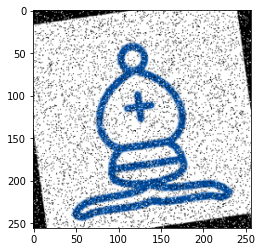

In [9]:
plt.imshow(np.transpose(images[10], (1,2,0)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.pool2 = nn.MaxPool2d(2,2)
        self.pool4 = nn.MaxPool2d(4,4)
        # First conv layers
        self.conv1 = nn.Conv2d(3, 64, 7, padding=3)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256,512, 7, padding=3)
        #self.conv5 = nn.Conv2d(12,6, 3, padding=1)
        #self.conv6 = nn.Conv2d(6,3, 1, padding=0)
        self.fc1 = nn.Linear(8192, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 12)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool4(x)
        x = F.relu(self.conv4(x))
        
        x = self.pool4(x)
        #x = F.relu(self.conv5(x))
        #x = F.relu(self.conv6(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# initialize the NN
model = ConvAutoencoder()

# Testing purposes 
X = torch.rand((1,3,256,256))
Y = model(X)
print(X.shape, Y.shape)

torch.Size([1, 3, 256, 256]) torch.Size([1, 12])


In [11]:
import torch.optim as optim
print(f'Using {["CPU", "CUDA"][torch.cuda.is_available()]}')
cuda_available = torch.cuda.is_available()

if cuda_available:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Using CUDA


In [16]:
# number of epochs to train the model
n_epochs = 10

model.train()
from time import time
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    for data in data_loader_train:
        #start = time()
        # Get both images, images_gray is the input, images is the expected output
        images, labels = data

        if cuda_available:
            images = images.cuda()
            labels = labels.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
       
        # calculate the loss
        
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
        #print(time() - start)
        #break
    # print avg training statistics 
    train_loss = train_loss/len(data_loader_train)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 79.195516
Epoch: 2 	Training Loss: 56.674798
Epoch: 3 	Training Loss: 6.124969
Epoch: 4 	Training Loss: 0.456070
Epoch: 5 	Training Loss: 0.118260
Epoch: 6 	Training Loss: 0.092537
Epoch: 7 	Training Loss: 0.017685
Epoch: 8 	Training Loss: 0.012900
Epoch: 9 	Training Loss: 0.010386
Epoch: 10 	Training Loss: 0.008599


In [17]:
model.eval()

correct, total = 0, 0

for data in data_loader_val:
    images, labels = data
    if cuda_available:
      images = images.cuda()
      labels = labels.cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    correct += sum(c).item()
    total += len(c)
  
print(f'ACC: {correct / total}')

ACC: 1.0


In [15]:
train_loss = train_loss/len(data_loader_train)
print('Epoch: {} \tTraining Loss: {:.6f}'.format(
    epoch, 
    train_loss
    ))

Epoch: 1 	Training Loss: 79.475534


In [ ]:
n_inputs = 5
model.cpu()
dataiter = iter(data_gray_loader_test)
X, _ = dataiter.next()[:5]
Y = model(X).cpu().detach().numpy()

dataiter = iter(data_loader_test)
X, _ = dataiter.next()
fig, axes = plt.subplots(nrows=2, ncols=n_inputs, sharex=True, sharey=True, figsize=(10,4))
for i in range(n_inputs):
    x = np.transpose(X[i+26], (1, 2, 0))
    y = np.transpose(Y[i+26], (1, 2, 0))
    axes[0][i].imshow(x)
    axes[1][i].imshow(y)

In [18]:
torch.save(model.state_dict(), 'model.pth')